In [1]:
import pandas as pd
import numpy as np
import orbit
from orbit.models import ETS
from orbit.models import DLT
from orbit.diagnostics.backtest import BackTester
from orbit.models import KTR
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt

/home/samuell/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file_path = '../data/WHO-COVID-19-global-data.csv'
date_column = 'Date_reported'
target_column = 'New_deaths'
df = pd.read_csv(file_path)
df = df[[date_column, target_column,'New_cases']]
df = df.groupby(date_column).sum().reset_index()
df = df.dropna()
df[date_column] = pd.to_datetime(df.pop(date_column), format='%Y-%m-%d')
#df.set_index(date_time, inplace=True, drop=False)

train = df.iloc[:-30]
valid = df.iloc[-30:]

In [3]:
ets = ETS(date_col=date_column, 
          response_col=target_column, 
          prediction_percentiles=[5, 95],
          seed=1)
train_ets = train[[date_column,target_column]].copy()

ets.fit(df=train_ets)

2023-11-19 19:10:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

In [4]:
def wmape(y_true, y_pred):
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()
forecast_df = valid[[date_column]]
p = ets.predict(df=forecast_df)
p = p.merge(valid, on=date_column, how='left')

print(wmape(p[target_column], p['prediction']))

2.9771676499507995


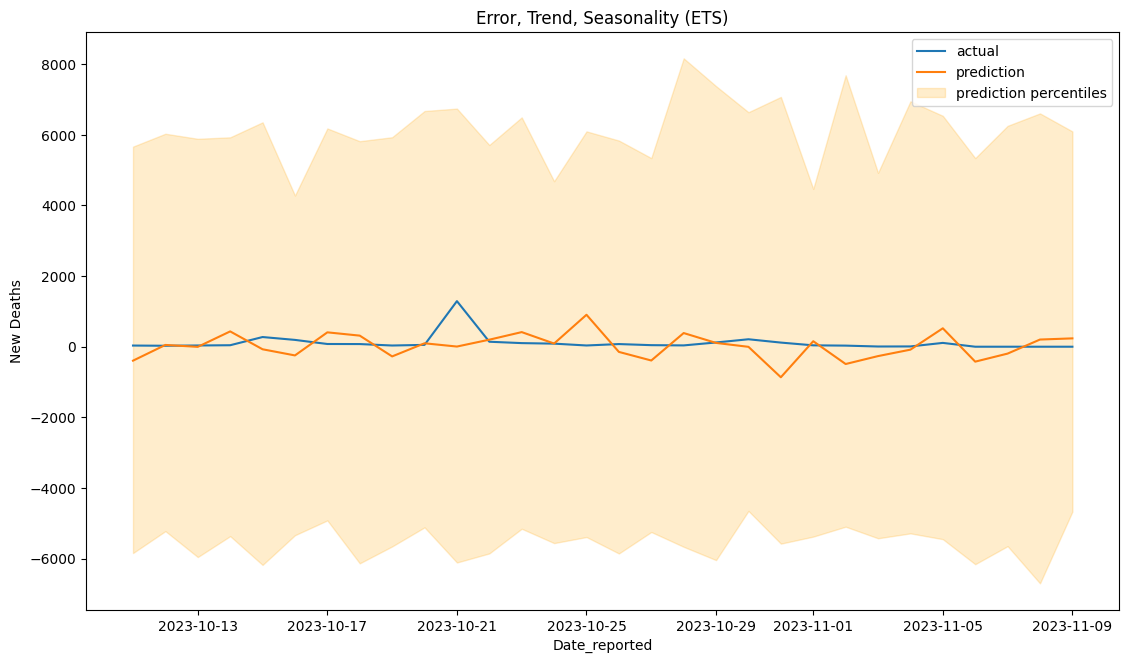

In [5]:
fig, ax = plt.subplots(1,1, figsize=(1280/96, 720/96))
ax.plot(p[date_column], p[target_column], label='actual')
ax.plot(p[date_column], p['prediction'], label='prediction')
ax.fill_between(p[date_column], p['prediction_5'], p['prediction_95'], alpha=0.2, color='orange', label='prediction percentiles')
ax.set_title('Error, Trend, Seasonality (ETS)')
ax.set_ylabel('New Deaths')
ax.set_xlabel(date_column)
ax.legend()
plt.show()

In [6]:
p[target_column].mean()
rmse=sqrt(mean_squared_error(p['prediction'],p[target_column]))
print(rmse)


434.0136796150002


In [7]:
scores = dict()
for global_trend_option in ['linear', 'loglinear', 'flat', 'logistic']:
    dlt = DLT(date_col=date_column, 
            response_col=target_column, 
            seasonality=7,
            prediction_percentiles=[5, 95],
            regressor_col=['New_cases'],
            regressor_sign=['='],
            regression_penalty='auto_ridge',
            damped_factor=0.8,
            seed=2, # if you get errors due to less than zero values, try a different seed
            global_trend_option=global_trend_option,
            verbose=False)

    bt = BackTester(df=train, 
                    model=dlt, 
                    forecast_len=90,
                    n_splits=5,
                    window_type='rolling')

    bt.fit_predict()
    predicted_df = bt.get_predicted_df()

    scores[global_trend_option] = wmape(predicted_df['actual'], predicted_df['prediction'])

chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status

chain 1 |█████     | 01:57 Iteration:   1 / 250 [  0%]  (Warmup)




chain 1 |██████████| 04:54 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |          | 05:10 Iteration: 226 / 250 [ 90%]  (Sampling)



chain 1 |██████████| 06:00 Sampling completed                     
chain 2 |██████████| 06:00 Sampling completed                     
chain 3 |██████████| 06:00 Sampling completed                     
chain 4 |██████████| 06:00 Sampling completed                     

chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status


chain 1 |█████     | 00:46 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |███████▌  | 03:22 Iteration: 100 / 250 [ 40%]  (Warmup)



chain 1 |██████████| 03:49 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |██████████| 05:54 Sampling completed                     
chain 2 |██████████| 05:54 Sampling completed                     
chain 3 |██████████| 05:54 Sampling completed                     
chain 4 |██████████| 05:54 Sampling completed                     

chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status





chain 1 |█████     | 01:11 Iteration:   1 / 250 [  0%]  (Warmup)




chain 1 |███████▌  | 03:53 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 04:31 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |██████████| 06:06 Sampling completed                     
chain 2 |██████████| 06:06 Sampling completed                     
chain 3 |██████████| 06:06 Sampling completed                     
chain 4 |██████████| 06:06 Sampling completed                     

chain 1 |          | 00:00 Status






chain 1 |█████     | 02:17 Iteration:   1 / 250 [  0%]  (Warmup)



chain 1 |███████▌  | 05:00 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 05:42 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |██████████| 06:24 Sampling completed                     
chain 2 |██████████| 06:24 Sampling completed                     
chain 3 |██████████| 06:24 Sampling completed                     
chain 4 |██████████| 06:24 Sampling completed                     

chain 1 |          | 00:00 Status




chain 1 |██▌       | 00:00 Status
chain 1 |█████     | 01:26 Iteration:   1 / 250 [  0%]  (Warmup)




chain 1 |██████████| 04:49 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |          | 05:32 Iteration: 226 / 250 [ 90%]  (Sampling)



chain 1 |██████████| 06:26 Sampling completed                     
chain 2 |██████████| 06:26 Sampling completed                     
chain 3 |██████████| 06:26 Sampling completed                     
chain 4 |██████████| 06:26 Sampling completed                     

chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status
chain 1 |█████     | 02:06 Iteration:   1 / 250 [  0%]  (Warmup)



chain 1 |███████▌  | 04:28 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |██████████| 04:46 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |          | 05:07 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 05:43 Sampling completed                     
chain 2 |██████████| 05:43 Sampling completed                     
chain 3 |██████████| 05:43 Sampling completed                     
chain 4 |██████████| 05:43 Sampling completed                     

chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status


chain 1 |█████     | 01:31 Iteration:   1 / 250 [  0%]  (Warmup)




chain 1 |          | 04:42 Iteration: 226 / 250 [ 90%]  (Sampling)





chain 1 |██████████| 05:36 Sampling completed                     
chain 2 |██████████| 05:36 Sampling completed                     
chain 3 |██████████| 05:36 Sampling completed                     
chain 4 |██████████| 05:36 Sampling completed                     

chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status





chain 1 |█████     | 01:48 Iteration:   1 / 250 [  0%]  (Warmup)



chain 1 |███████▌  | 04:26 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 05:07 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |██████████| 06:18 Sampling completed                     
chain 2 |██████████| 06:18 Sampling completed                     
chain 3 |██████████| 06:18 Sampling completed                     
chain 4 |██████████| 06:18 Sampling completed                     

chain 1 |          | 00:00 Status



chain 1 |█████     | 01:55 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |███████▌  | 04:35 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |██████████| 05:18 Iteration: 200 / 250 [ 80%]  (Warmup)


chain 1 |          | 06:04 Iteration: 226 / 250 [ 90%]  (Sampling)


chain 1 |██████████| 06:36 Sampling completed                     
chain 2 |██████████| 06:36 Sampling completed                     
chain 3 |██████████| 06:36 Sampling completed                     
chain 4 |██████████| 06:36 Sampling completed                     

chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status

chain 1 |█████     | 00:49 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |███████▌  | 03:24 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 04:04 Iteration: 200 / 250 [ 80%]  (Warmup)


chain 1 |          | 04:46 Iteration: 226 / 250 [ 90%]  (Sampling)



chain 1 |██████████| 06:03 Sampling completed                     
chain 2 |██████████| 06:03 Sampling completed                     
chain 3 |██████████| 06:03 Sampling completed                     
chain 4 |██████████| 06:03 Sampling completed                     

chain 1 |          | 00:00 Status



chain 1 |█████     | 01:21 Iteration:   1 / 250 [  0%]  (Warmup)




chain 1 |          | 03:56 Iteration: 226 / 250 [ 90%]  (Sampling)





chain 1 |██████████| 04:46 Sampling completed                     
chain 2 |██████████| 04:46 Sampling completed                     
chain 3 |██████████| 04:46 Sampling completed                     
chain 4 |██████████| 04:46 Sampling completed                     

chain 1 |          | 00:00 Status



chain 1 |█████     | 00:23 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |██████████| 02:58 Iteration: 200 / 250 [ 80%]  (Warmup)


chain 1 |          | 03:26 Iteration: 226 / 250 [ 90%]  (Sampling)




chain 1 |██████████| 04:27 Sampling completed                     
chain 2 |██████████| 04:27 Sampling completed                     
chain 3 |██████████| 04:27 Sampling completed                     
chain 4 |██████████| 04:27 Sampling completed                     

chain 1 |          | 00:00 Status



chain 1 |█████     | 01:41 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |███████▌  | 04:11 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |██████████| 04:50 Iteration: 200 / 250 [ 80%]  (Warmup)


chain 1 |          | 05:25 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 05:50 Sampling completed                     
chain 2 |██████████| 05:50 Sampling completed                     
chain 3 |██████████| 05:50 Sampling completed                     
chain 4 |██████████| 05:50 Sampling completed                     

chain 1 |          | 00:00 Status


chain 1 |█████     | 00:12 Iteration:   1 / 250 [  0%]  (Warmup)



chain 1 |███████▌  | 02:17 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 02:55 Iteration: 200 / 250 [ 80%]  (Warmup)
chain 1 |          | 03:37 Iteration: 226 / 250 [ 90%]  (Sampling)





chain 1 |██████████| 05:39 Sampling completed                     
chain 2 |██████████| 05:39 Sampling completed                     
chain 3 |██████████| 05:39 Sampling completed                     
chain 4 |██████████| 05:39 Sampling completed                     

chain 1 |          | 00:00 Status





chain 1 |██▌       | 00:00 Status
chain 1 |█████     | 01:02 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |███████▌  | 03:27 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 04:03 Iteration: 200 / 250 [ 80%]  (Warmup)


chain 1 |          | 04:45 Iteration: 226 / 250 [ 90%]  (Sampling)



chain 1 |██████████| 05:58 Sampling completed                     
chain 2 |██████████| 05:58 Sampling completed                     
chain 3 |██████████| 05:58 Sampling completed                     
chain 4 |██████████| 05:58 Sampling completed                     

chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status

chain 1 |█████     | 02:08 Iteration:   1 / 250 [  0%]  (Warmup)




chain 1 |          | 05:06 Iteration: 226 / 250 [ 90%]  (Sampling)





chain 1 |██████████| 05:47 Sampling completed                     
chain 2 |██████████| 05:47 Sampling completed                     
chain 3 |██████████| 05:47 Sampling completed                     
chain 4 |██████████| 05:47 Sampling completed                     

chain 1 |          | 00:00 Status




chain 1 |█████     | 01:25 Iteration:   1 / 250 [  0%]  (Warmup)



chain 1 |          | 04:39 Iteration: 226 / 250 [ 90%]  (Sampling)





chain 1 |██████████| 05:25 Sampling completed                     
chain 2 |██████████| 05:25 Sampling completed                     
chain 3 |██████████| 05:25 Sampling completed                     
chain 4 |██████████| 05:25 Sampling completed                     

chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status




KeyboardInterrupt: 

In [ ]:
scores

In [ ]:
best_global_trend_option = min(scores, key=scores.get)    

In [8]:
dlt = DLT(date_col=date_column, 
        response_col=target_column, 
        seasonality=7,
        prediction_percentiles=[5, 95],
        regressor_col=['New_cases'],
        regressor_sign=['='],
        regression_penalty='auto_ridge',
        damped_factor=0.8,
        seed=2,
global_trend_option='loglinear',
        verbose=False,)
dlt.fit(df=train)

p = dlt.predict(df=valid[[date_column, 'New_cases']])
p = p.merge(valid, on=date_column, how='left')

print(wmape(p[target_column], p['prediction']))










































chain 1 |█████     | 01:36 Iteration:   1 / 250 [  0%]  (Warmup)

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(1280/96, 720/96))
ax.plot(p[date_column], p[target_column], label='actual')
ax.plot(p[date_column], p['prediction'], label='prediction')
ax.fill_between(p[date_column], p['prediction_5'], p['prediction_95'], alpha=0.2, color='orange', label='prediction percentiles')
ax.set_title('Damped Local Trend (DLT)')
ax.set_ylabel('New Deaths')
ax.set_xlabel(date_column)
ax.legend()
plt.show()

In [ ]:
p[target_column].mean()
rmse=sqrt(mean_squared_error(p['prediction'],p[target_column]))
print(rmse)


In [ ]:
ktr = KTR(date_col=date_column, 
        response_col=target_column, 
        seasonality=[30, 90,180,360],
        prediction_percentiles=[5, 95],
        regressor_col=['New_cases'],
        seed=2,
        verbose=False)

ktr.fit(df=train)

p = ktr.predict(df=valid[[date_column, 'New_cases']])
p = p.merge(valid, on=date_column, how='left')

print(wmape(p[target_column], p['prediction']))

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(1280/96, 720/96))
ax.plot(p[date_column], p[target_column], label='actual')
ax.plot(p[date_column], p['prediction'], label='prediction')
ax.fill_between(p[date_column], p['prediction_5'], p['prediction_95'], alpha=0.2, color='orange', label='prediction percentiles')
ax.set_title('Damped Local Trend (DLT)')
ax.set_ylabel('New Deaths')
ax.set_xlabel(date_column)
ax.legend()
plt.show()

In [ ]:
p[target_column].mean()
rmse=sqrt(mean_squared_error(p['prediction'],p[target_column]))
print(rmse)
